## Main idea
In Interactive Broker(IB) there is a new service that allow user to predict event outcome called ForecastTrader. These Forecast Contract might share the same underlying with traditional option, one such eample is:

Will [expiration] CME E-mini S&P 500 Index Futures settle above $6,050 on February 14 2025?

User can buy the 'Yes' or 'No' outcome, and when the event concluded the correct side will be paid and the wrong side would lose all the bet.
The price of each outcome range from $[0,1]\$$ and the correct side would be paid $\$1$ for each contract.

## Task
Can we construct a risk-free (almost always)positive payout portfolio using these contract and other financial tools?

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Notation

$C$: call option price

$S$: asset price

$K$: strike price

$p$: probablity (binary option price)

$T$: binary option strike price

To calculate the PnL of the call option as a function of the asset price:
$$\text{PnL}_{\text{call}} = \max{(S-K, \ 0)}-C$$

To calculate the PnL of the NO binary option as a function of the asset price
$$\text{PnL}_{\text{NO}} = 1(S<T) - p$$

The Future price can be written as:
$$F_t = S_t e^{r (T-t)}$$

note that since we will open and close the trade within the same day. One trading date has 6.5 hours. And one year has 8760 hours. So $e^{r\times \frac{6.5}{8760}}\approx 1$. So, to relate the future price and the asset price in our purpose, we can do:
$$S=F\times \frac{S_o}{F_o}e^{-r\delta t}\approx F\times \frac{S_o}{F_o}\, ,$$
where $S_o, F_o$ are the asset and future price at matket open. And $\delta t=6.5/8760$, which is the risk-free interest that compunded within the trading hours.

In [4]:
def cal_pnl_call_option(S, K, C):
    return np.maximum(S-K, 0) - C

def cal_pnl_put_option(S, K, C):
    return np.maximum(K-S, 0) - C

def cal_pnl_YES(S, T, prob):
    return np.where(S >= T, 1, 0) - prob

def cal_pnl_NO(S, T, prob):
    return np.where(S >= T, 0, 1) - prob


## Testing the PnL functions

In [6]:
S_now = 21_621
deltaS = 500
S = np.arange(S_now-deltaS, S_now+deltaS)

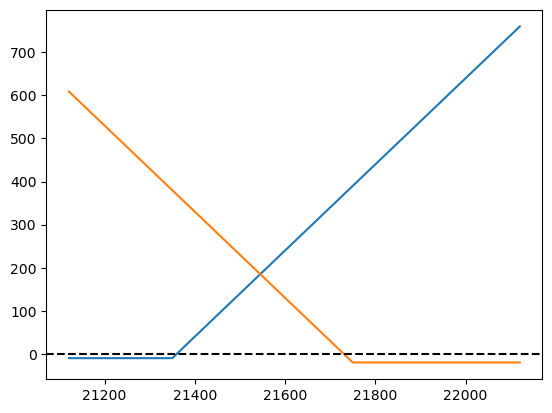

In [7]:
pnl_call_option = cal_pnl_call_option(S, 21350, 10)
pnl_put_option = cal_pnl_put_option(S, 21750, 20)
plt.plot(S, pnl_call_option)
plt.plot(S, pnl_put_option)
plt.axhline(y=0,color='black',linestyle='--')
plt.show()

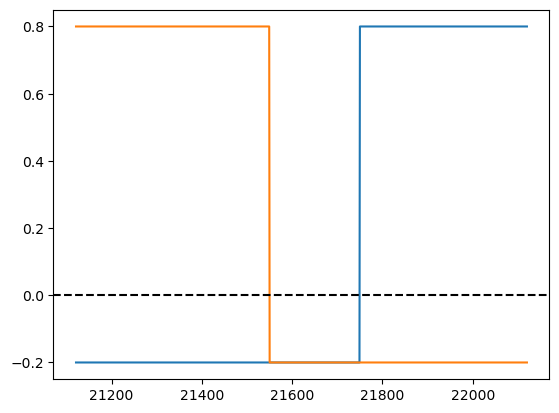

In [8]:
pnl_yes = cal_pnl_YES(S, 21750, 0.2)
pnl_no = cal_pnl_NO(S, 21550, 0.2)
plt.plot(S, pnl_yes)
plt.plot(S, pnl_no)
plt.axhline(y=0,color='black',linestyle='--')
plt.show()

# Application

In [10]:
# Future price at the reference time (open of the day)
F_o = 21518                # <- input
S_o = 21374                # <- input


In [11]:
# the picked binary (future) strike price
F_T = 21800                # <- input from IB ForecastTrader
# the binary contract price (the probablity of "NO")
prob = 1 - (1/100) * 5                # <- input from IB ForecastTrader
# convert to strike price of the asset
T = F_T * S_o / F_o

print(f"strike price of the asset: {T:.3f}")

strike price of the asset: 21654.113


In [12]:
# strike price of the call option
K = 21600                # <- input from IB option

C_thredhold = (-K+T) * (1-prob)
print(f"Need to: C < {C_thredhold:.4f}")

Need to: C < 2.7056


In [13]:
# premium of the option
C = 0.9                # <- input from IB option

if not(T >= C + K):
    raise Exception(f"The breakeven {C + K:.3f} of the call option needs to be smaller then the strike price {T:.3f} of the binary option")


In [14]:
S_now = T
deltaS = 500
S = np.arange(S_now-deltaS, S_now+deltaS)

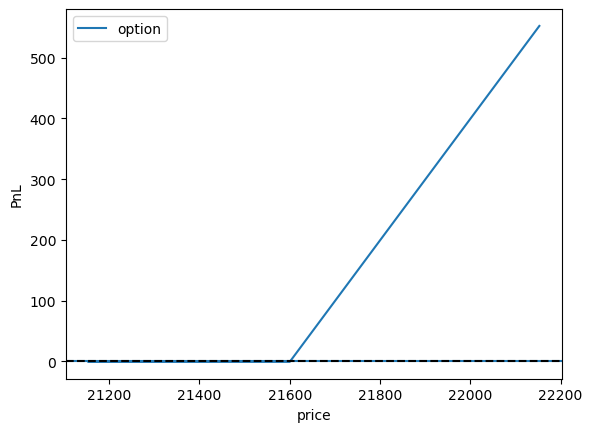

In [15]:
pnl_call_option = cal_pnl_call_option(S, K, C)

plt.plot(S, pnl_call_option, label='option')
plt.axhline(0)
plt.xlabel("price")
plt.ylabel("PnL")
plt.legend()
plt.axhline(y=0,color='black',linestyle='--')
plt.show()


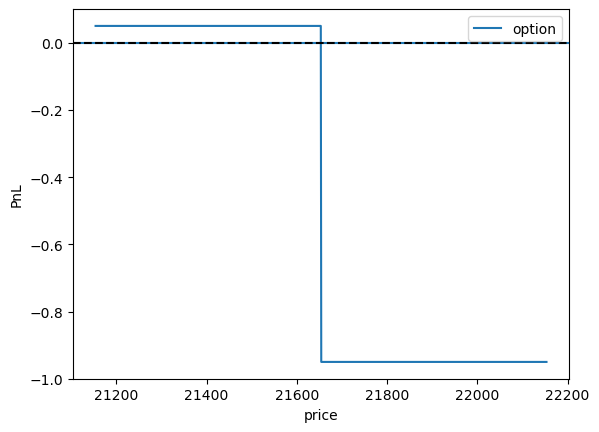

In [16]:
pnl_no = cal_pnl_NO(S, T, prob)

plt.plot(S, pnl_no, label='option')
plt.axhline(0)
plt.xlabel("price")
plt.ylabel("PnL")
plt.legend()
plt.axhline(y=0,color='black',linestyle='--')
plt.show()


17.999999999999986 1.1102230246251565e-16


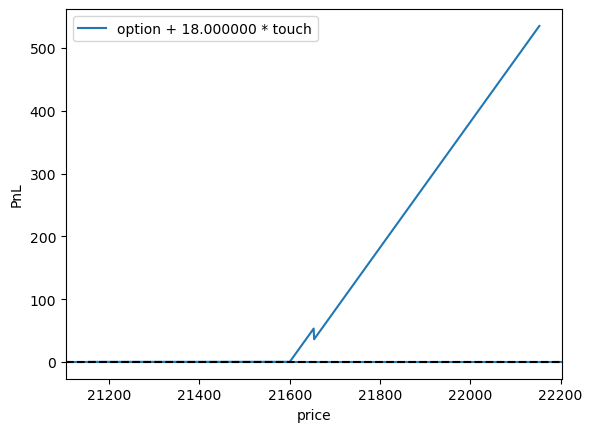

In [17]:
# checking can arb or not
n_shares0 = C / (1-prob)
pnl_sum0 = pnl_no * n_shares0 + pnl_call_option
print(n_shares0, min(pnl_sum0))

plt.plot(S, pnl_sum0, label=f'option + {n_shares0:2f} * touch')
plt.axhline(0)
plt.xlabel("price")
plt.ylabel("PnL")
plt.legend()
plt.axhline(y=0,color='black',linestyle='--')
plt.show()


if min(pnl_sum0) < 0 and abs(min(pnl_sum0)) > 1e-10:
    raise Exception("Can't arb")

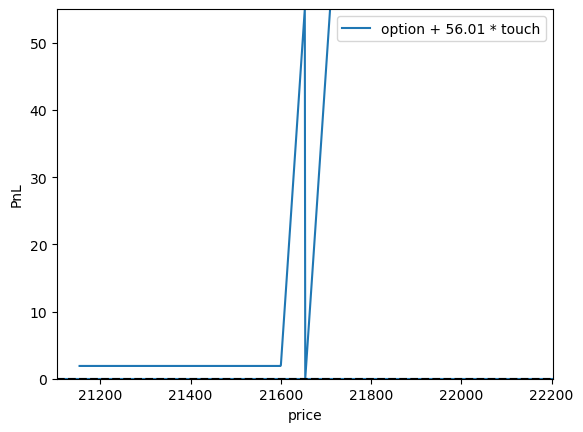

Cost: 54.11; Gain: 1.90
Return: 3.51%


In [18]:
# checking can arb or not
n_shares = (T - (C+K)) / (prob)
pnl_sum = pnl_no * n_shares + pnl_call_option


plt.plot(S, pnl_sum, label=f'option + {n_shares:.2f} * touch')
plt.axhline(0)
plt.xlabel("price")
plt.ylabel("PnL")
plt.legend()

plt.ylim(0, max(pnl_sum[S < T]))
plt.axhline(y=0,color='black',linestyle='--')
plt.show()

cost = n_shares * prob + C
gain_LHS = min(pnl_sum[S < T])
print(f"Cost: {cost:.2f}; Gain: {gain_LHS:.2f}")

print(f"Return: {gain_LHS / cost* 100:.2f}%")